In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
threshold = 150
frame=None
    
has_active_cam = False

In [3]:
def show_image(image, title: str = "Sem Título"):
    plt.figure(figsize=(7, 4))
    plt.imshow(image, cmap = 'gray')
    plt.title(title)
    plt.show()

In [4]:
def rotateImage(image_list, bounding_box):
    x,y,w,h = bounding_box
    new_image_list = []

    for image in image_list:
        if w < h and y == 0:
            image  = cv2.rotate(image, cv2.ROTATE_180)
        elif w > h and x == 0:
            image  = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        elif w > h:
            image  = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        
        new_image_list.append(image)

    return new_image_list

In [5]:
def acharCentroidEPicos(coutornos)->None:
    m = cv2.moments(coutornos)
    
    cx = int(m['m10']/m['m00'])
    xy = int(m['m01']/m['m00'])
    return (cx,xy)

In [6]:
def baseProcessing(src_img, threshold):
    image = src_img.copy()
    # Transformação Binária
    binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY_INV)[1]

    # Operação de Fechamento
    kernel = np.ones((5, 5), np.uint8) 
    binary_close_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

    return binary_close_image

In [7]:
def findContours(image, source_image):
    src_img = source_image.copy()

    for i in range(2):
        num_labels, labeled_image = cv2.connectedComponents(image)
        component_mask = np.uint8(labeled_image == 2) * 255
        maior=0
        labelMaior=0
        for component in range(1,num_labels+1):
            area = np.uint8(labeled_image==component)*255
            cv2.countNonZero(area)
            if(cv2.countNonZero(area)>maior):
                maior = cv2.countNonZero(area)
                labelMaior=component

        component_mask= np.uint8(labeled_image == labelMaior) * 255
        # Encontra os contornos do componente
        contours= cv2.findContours(component_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
        #menor forma para representar os contornos
        cnt = contours[0]
        # cx,cy = acharCentroidEPicos(cnt)

        bounding_box = cv2.boundingRect(cnt)

        image, src_img, source_image = rotateImage([image, src_img, source_image], bounding_box)


    


    
    src_img = cv2.drawContours(src_img, contours, -1,(0,255,0),thickness=2)
    # show_image(source_img)

    return (source_image, src_img, image, bounding_box)



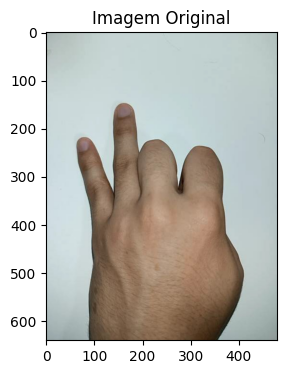

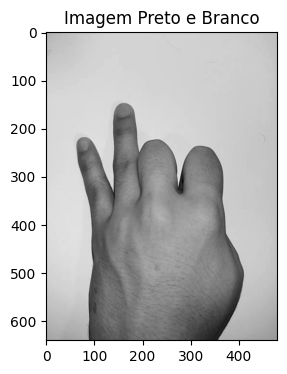

In [8]:
file_path = "image_tests/image5.jpeg"
base_image = cv2.imread(file_path, -1)
base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

image = cv2.imread(file_path, 0)

show_image(base_image, "Imagem Original")
show_image(image, "Imagem Preto e Branco")

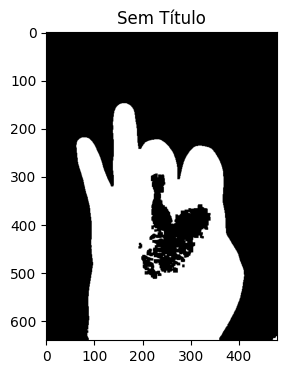

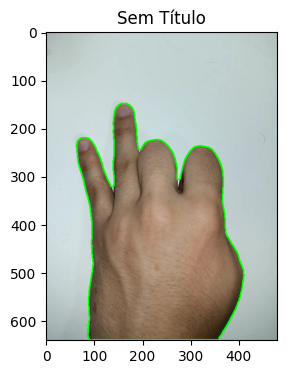

In [9]:
processed_image = baseProcessing(image, threshold)
show_image(processed_image)
base_image, image_with_contour, processed_image, bounding_box = findContours(processed_image, base_image)

show_image(image_with_contour)

In [10]:
def createBox(image, bounding_box):
    red = (255, 0, 0)
    x,y,w,h = bounding_box
    print(bounding_box)
    image_with_box = cv2.rectangle(image,(x,y),(x+w,y+h),red,2)

    return image_with_box

(63, 148, 349, 492)


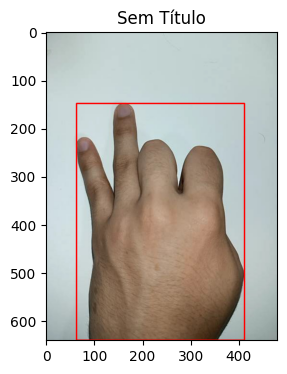

In [11]:
image_with_bouding_box = createBox(base_image, bounding_box)
show_image(image_with_bouding_box)

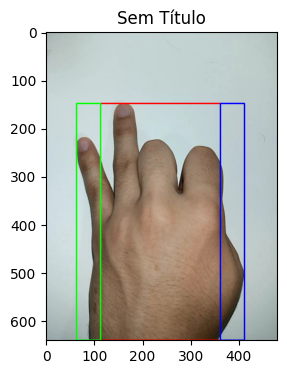

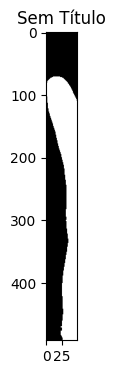

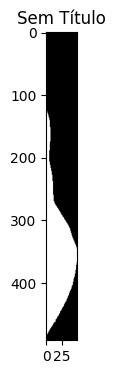

7454 10913 8092


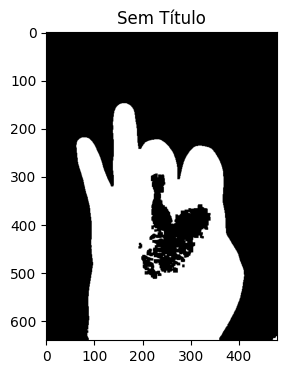

False

In [12]:
def thumbDetector(processed_image, source_image, bounding_box, detection_area: int=30):
    has_thumb = False
    src_img = source_image.copy()
    binary_image = processed_image.copy()
    x,y,w,h = bounding_box
    green = (0, 255, 0)
    blue = (0, 0, 255)
    image_with_box = cv2.rectangle(src_img, (x,y), (x+detection_area,y+h), green, 2)
    image_with_box = cv2.rectangle(image_with_box, (x+w-detection_area,y), (x+w,y+h), blue, 2)
    show_image(image_with_box)

    binary_image_left_section = binary_image[y: y+h, x: x+detection_area]
    binary_image_right_section = binary_image[y : y+h, x+w-detection_area : x+w]
    binary_left_sum = int(binary_image_left_section.sum())//255
    binary_right_sum = int(binary_image_right_section.sum())//255
    binary_7percent_sum = int(binary_image.sum()//255*0.07)
    show_image(binary_image_left_section)
    show_image(binary_image_right_section)
    print(binary_7percent_sum, binary_left_sum, binary_right_sum)


    if (binary_left_sum < binary_7percent_sum or binary_right_sum < binary_7percent_sum) and (binary_left_sum > binary_7percent_sum or binary_right_sum > binary_7percent_sum):
        has_thumb = True
    
    return has_thumb

has_thumb = thumbDetector(processed_image, image_with_bouding_box, bounding_box, detection_area=50)
show_image(processed_image)
has_thumb

In [ ]:
def getPeaks(processed_image, source_image, bounding_box):
    src_img = source_image.copy()
    binary_image = processed_image.copy()
    x,y,w,h = bounding_box
    red = (255, 0, 0)
    blue = (0, 0, 255)
    green = (0, 255, 0)
    image_with_centroid = cv2.circle(src_img, (int(x + w/2), int(y + h/2)), 5, red, -1)
    image_with_centroid = cv2.line(image_with_centroid, (0, int(y + h/2)), (h, int(y + h/2)), blue, 1)
    # show_image(image_with_centroid)

    binary_image_above_centroid = binary_image[y: int(y + h/2), x: x+w]
    # show_image(binary_image_above_centroid)
    
    contours= cv2.findContours(binary_image_above_centroid, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0]
    # print(contours)

    image_above_centroid = src_img[y: int(y + h/2), x: x+w]
    image_with_contours = cv2.drawContours(image_above_centroid, contours, -1, green, thickness=2)
    # show_image(image_with_contours)
    # print(image_with_contours[0][0])

    new_binary_image_contours = binary_image_above_centroid.copy()
    for index_row, row in enumerate(image_with_contours):
        for index_col, col in enumerate(row):
            if col[1] == 255:
                new_binary_image_contours[index_row, index_col] = 255

            else:      
                new_binary_image_contours[index_row, index_col] = 0
    
    show_image(new_binary_image_contours)

    for index_row, row in enumerate(new_binary_image_contours):
    # flag = 0
    # x_axis = 0
    # while flag < 4:
        slice_bin_img_contours = new_binary_image_contours[:index_row, :]
        ret, labels = cv2.connectedComponents(slice_bin_img_contours)
        for label in range(1,ret):
            mask = np.array(labels, dtype=np.uint8)
            mask[labels == label] = 255
            if ret == 2:
                show_image(mask)
                flag = 8
                break


    #     x_axis += 1


    # slice_bin_img_contours = new_binary_image_contours[:130, :]
    # # show_image(a)
    # ret, labels = cv2.connectedComponents(slice_bin_img_contours)
    # print(len(labels))
    # print(ret)
    # for label in range(1,ret):
    #     mask = np.array(labels, dtype=np.uint8)
    #     mask[labels == label] = 255
    #     show_image(mask)
    

    # image_with_box = cv2.rectangle(src_img, (x,y), (x+detection_area,y+h), green, 2)
    # image_with_box = cv2.rectangle(image_with_box, (x+w-detection_area,y), (x+w,y+h), blue, 2)

    # binary_image_left_section = binary_image[y: y+h, x: x+detection_area]
    # binary_image_right_section = binary_image[y : y+h, x+w-detection_area : x+w]
    # binary_left_sum = int(binary_image_left_section.sum())//255
    # binary_right_sum = int(binary_image_right_section.sum())//255
    # binary_7percent_sum = int(binary_image.sum()//255*0.07)
    # show_image(binary_image_left_section)
    # show_image(binary_image_right_section)
    # print(binary_7percent_sum, binary_left_sum, binary_right_sum)

getPeaks(processed_image, image_with_bouding_box, bounding_box)